# Import packages and load the dataset

In [1]:
# Import data manipulation packages

import pandas as pd
import numpy as np

# Import visualization packages

import matplotlib.pyplot as plt
import seaborn as sns

# Display all columns 
pd.set_option('display.max_columns', None)

# Import modelling packages
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Import evaluation and modelling tools

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler 


Next, we use `Pandas` to load our dataset as a dataframe object

In [2]:
df0 = pd.read_csv(r'C:/Users/lenovo/Downloads/HR_Salifort.csv')

# Clean data

## Initial cleaning and overview

In [3]:
print(df0.columns)

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')


In [4]:
# Correct the column names of the dataset

df0 = df0.rename(columns = {
    "average_montly_hours":"avg_hours_month",
    "time_spend_company":"tenure_years",
    "Work_accident":"work_accident",
    "promotion_last_5years":"is_promoted_5y",
    "Department":"department",
    "salary":"salary_cat"
})

# Print a few rows to check
print(df0.head())

   satisfaction_level  last_evaluation  number_project  avg_hours_month  \
0                0.38             0.53               2              157   
1                0.80             0.86               5              262   
2                0.11             0.88               7              272   
3                0.72             0.87               5              223   
4                0.37             0.52               2              159   

   tenure_years  work_accident  left  is_promoted_5y department salary_cat  
0             3              0     1               0      sales        low  
1             6              0     1               0      sales     medium  
2             4              0     1               0      sales     medium  
3             5              0     1               0      sales        low  
4             3              0     1               0      sales        low  


## Check for dupliacted and missing values

In [5]:
df0.isnull().sum(axis=0) # No duplicates were found

satisfaction_level    0
last_evaluation       0
number_project        0
avg_hours_month       0
tenure_years          0
work_accident         0
left                  0
is_promoted_5y        0
department            0
salary_cat            0
dtype: int64

In [6]:
df0.duplicated().sum() # 3008 duplicate entries were found

3008

It is very unlikely that so many columns could have the same values, drop duplicates.

In [7]:
# Delete duplicates
df0.drop_duplicates(keep='first')

# Check the size
df0.shape

(14999, 10)

Next, let us view some information about the columns and basic stats

In [8]:
df0.info() # only department and salary are non-numeric columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   satisfaction_level  14999 non-null  float64
 1   last_evaluation     14999 non-null  float64
 2   number_project      14999 non-null  int64  
 3   avg_hours_month     14999 non-null  int64  
 4   tenure_years        14999 non-null  int64  
 5   work_accident       14999 non-null  int64  
 6   left                14999 non-null  int64  
 7   is_promoted_5y      14999 non-null  int64  
 8   department          14999 non-null  object 
 9   salary_cat          14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [9]:
df0.describe() # 23.8% in the dataset have left, tenure_years is right-skewed

,satisfaction_level,last_evaluation,number_project,avg_hours_month,tenure_years,work_accident,left,is_promoted_5y
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


The `tenure_years` column must have many outliers.

## Remove unneeded columns

In [10]:
# Remove the department and salary category columns for the optimal number of features

df_num = df0.drop(['salary_cat', 'department'], axis=1)
print(df_num.head())

   satisfaction_level  last_evaluation  number_project  avg_hours_month  \
0                0.38             0.53               2              157   
1                0.80             0.86               5              262   
2                0.11             0.88               7              272   
3                0.72             0.87               5              223   
4                0.37             0.52               2              159   

   tenure_years  work_accident  left  is_promoted_5y  
0             3              0     1               0  
1             6              0     1               0  
2             4              0     1               0  
3             5              0     1               0  
4             3              0     1               0  


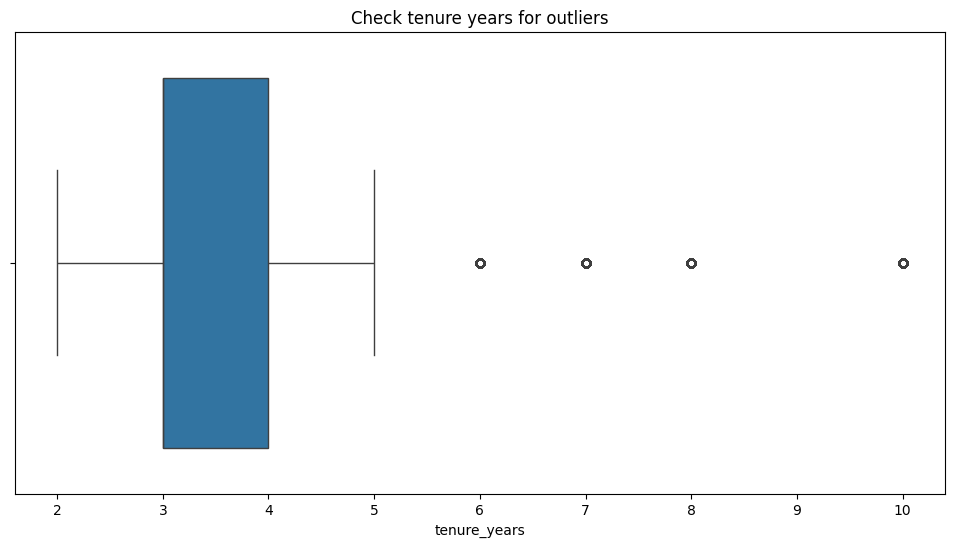

In [11]:
# Checking `tenure_years` for outliers

plt.figure(figsize=(12,6))

sns.boxplot(x=df0['tenure_years'])

plt.title('Check tenure years for outliers')
plt.show()

### Remove outliers from the data for fitting the model

In [12]:
# Assign needed percentiles and IQR to variables

tenure_p25 = df_num['tenure_years'].quantile(0.25)
tenure_p75 = df_num['tenure_years'].quantile(0.75)
tenure_iqr = tenure_p75 - tenure_p25

# Use outlier thresholds to define them
tenure_upper = tenure_p75 + 1.5*tenure_iqr

# Remove tenure outliers from `df_num`
df_num=df_num[df_num['tenure_years'] < tenure_upper]

# Check the values
print(df_num['tenure_years'].max())

5


## Split the data and scale features

In [13]:
# Isolate the dependent variable in y, and predictors in X

X = df_num.drop(['left'], axis=1)
y = df_num['left']

In [14]:
# Use `train_test_split` with 20% test sample size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
# Use `StandardScaler` for best performance
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

 For now, let us explore the data in visualizations before continuing with clustering model build

## Data visualization

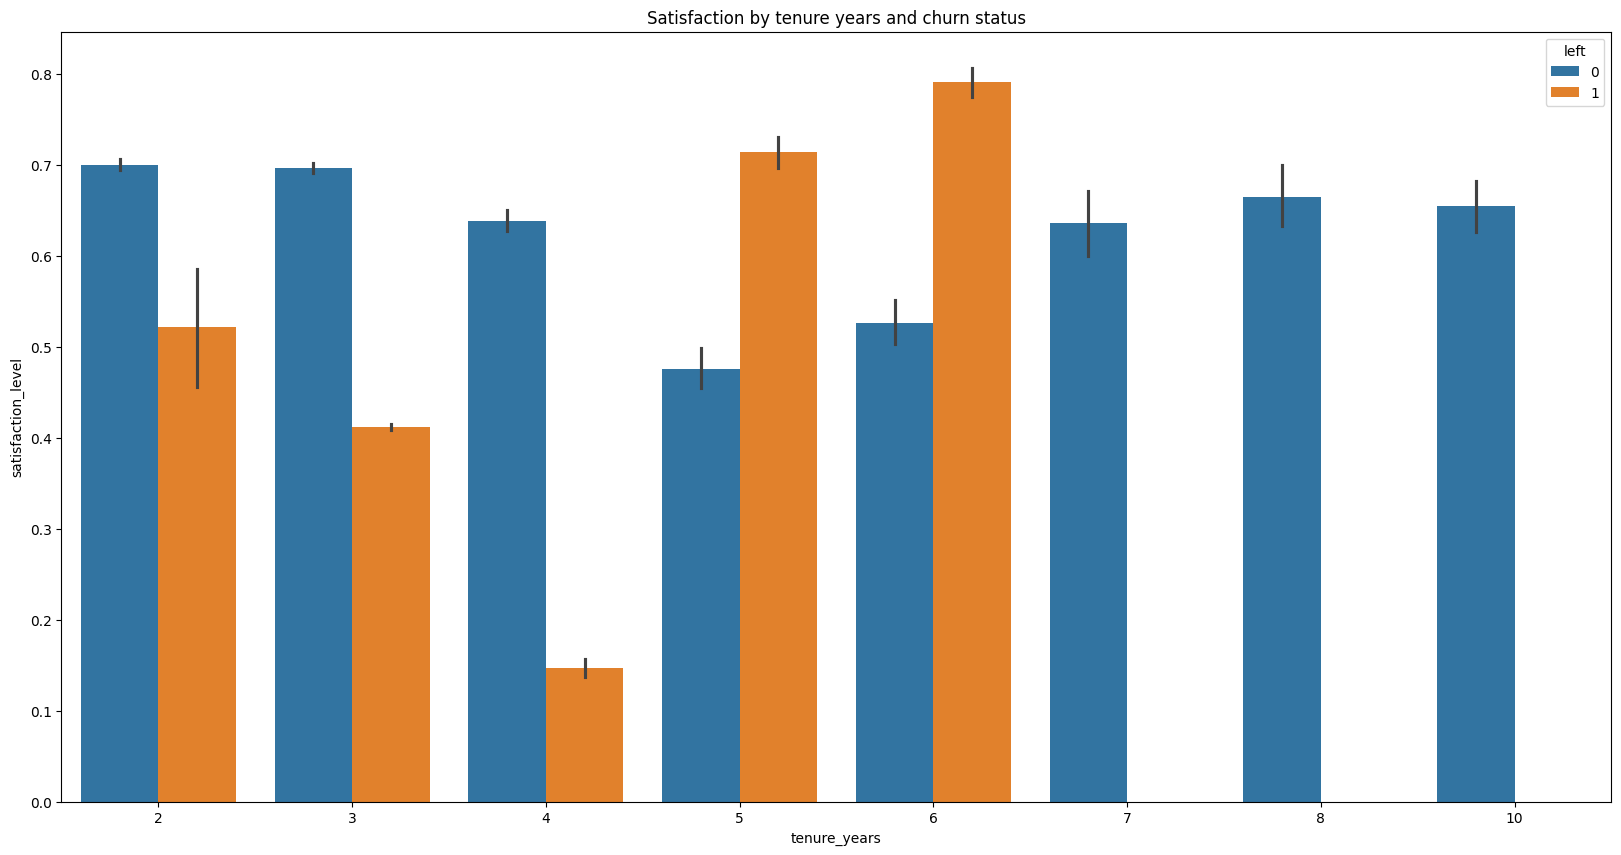

In [16]:
# Plot left v.stayed by `tenure_year` and `satisfaction_level`
plt.figure(figsize=(20,10))

sns.barplot(
    data=df0, x='tenure_years', y='satisfaction_level', hue='left'
)

plt.title("Satisfaction by tenure years and churn status")
plt.show()

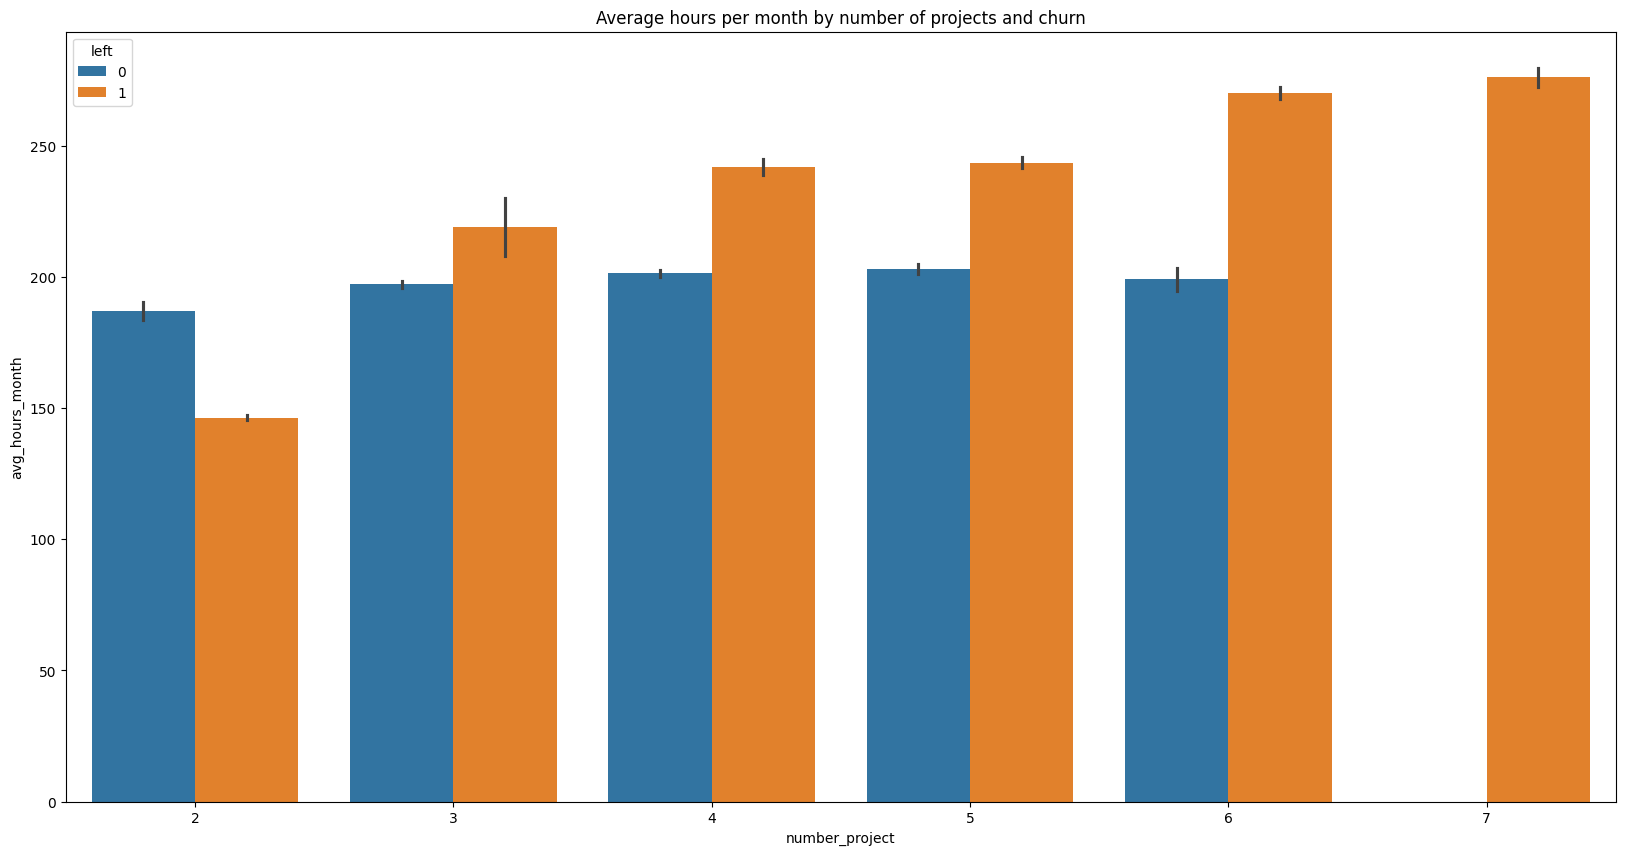

In [17]:
# Plot left v. stayed by number of projects and work hour lengths

plt.figure(figsize=(20, 10))

sns.barplot(data=df0, x='number_project', y='avg_hours_month', hue='left')

plt.title("Average hours per month by number of projects and churn")
plt.show()

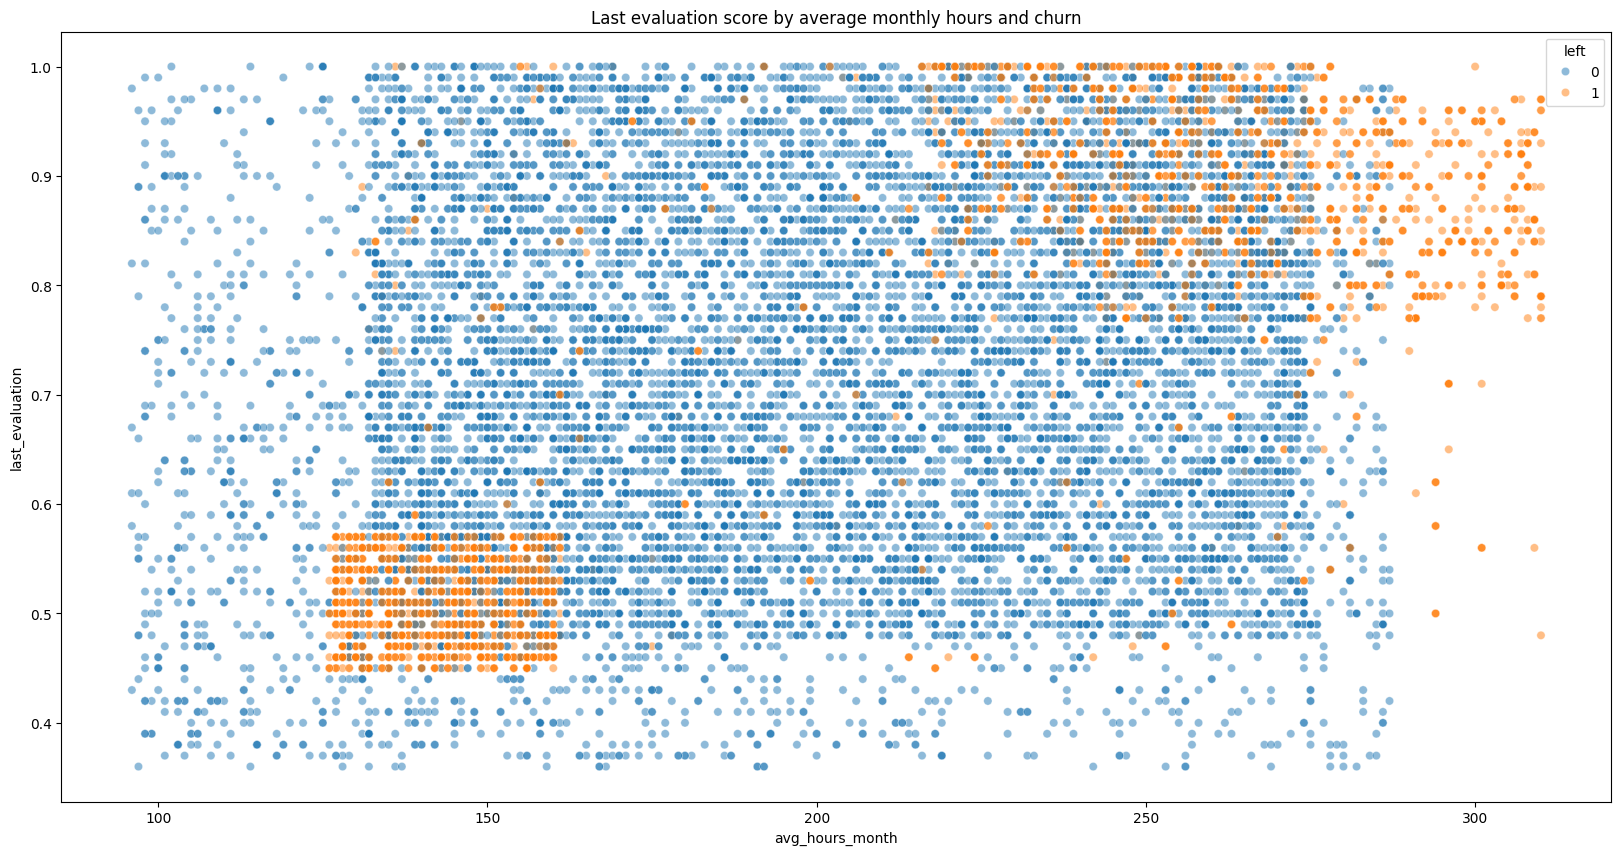

In [18]:
# Plot last evaluation by monthly average hours with churn as hue
plt.figure(figsize=(20,10))

sns.scatterplot(data=df0, x="avg_hours_month", y="last_evaluation", hue="left", alpha=0.5)

plt.title("Last evaluation score by average monthly hours and churn")
plt.show()

<Figure size 2000x1000 with 0 Axes>

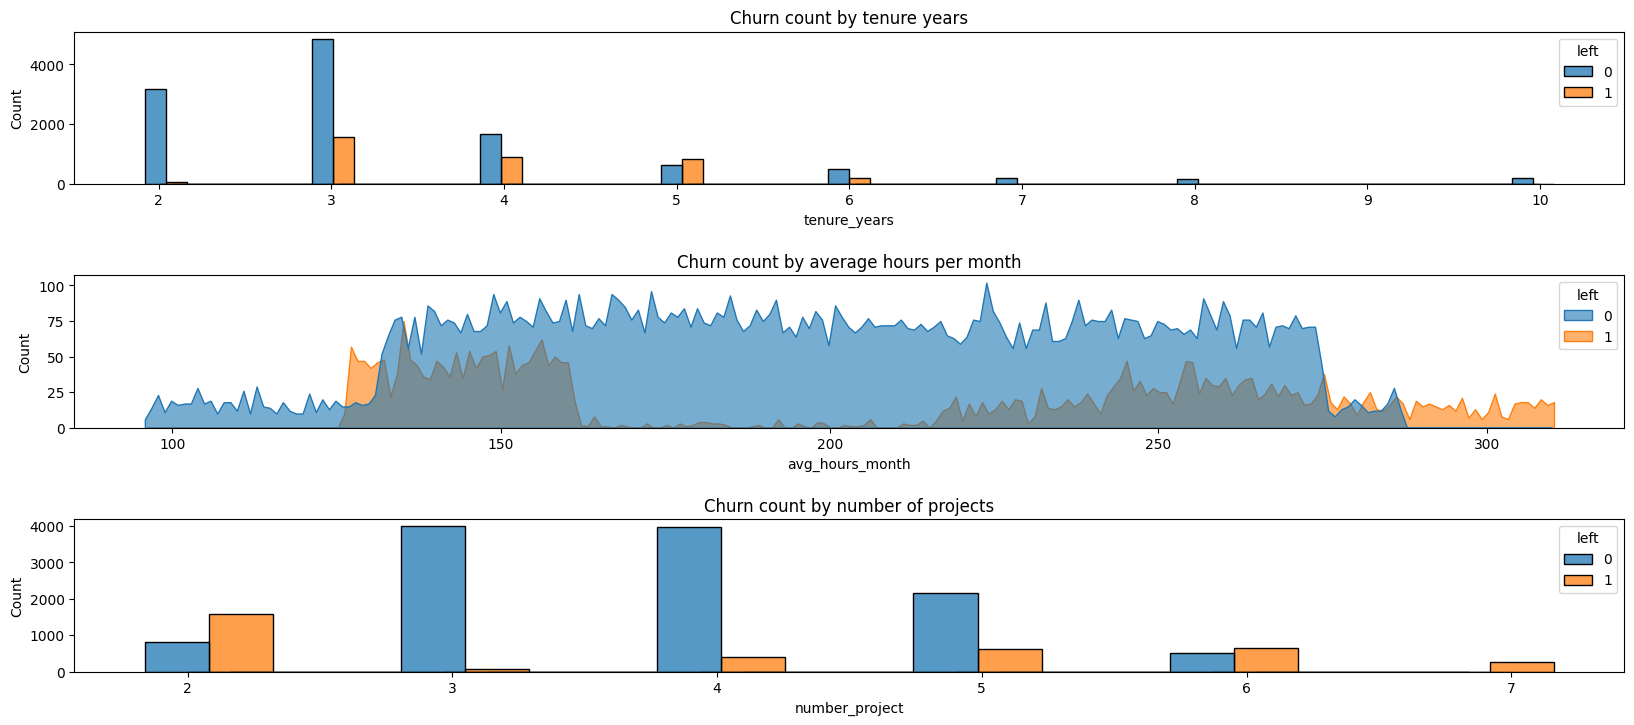

In [19]:
# Count of left and stayed employees by tenure years
plt.figure(figsize=(20,10))

fig,ax = plt.subplots(3,1, figsize=(20, 8))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.6, hspace=0.6)

sns.histplot(data=df0, x='tenure_years', hue='left', shrink=3, multiple='dodge', ax=ax[0])
sns.histplot(data=df0, x='avg_hours_month', discrete=True, element="poly", shrink=0.7, hue='left', multiple='dodge', ax=ax[1], alpha=0.6)
sns.histplot(data=df0, x='number_project', hue='left', shrink=3, multiple='dodge', ax=ax[2])

ax[0].set_title("Churn count by tenure years")
ax[1].set_title("Churn count by average hours per month")
ax[2].set_title("Churn count by number of projects")
plt.show()

Text(0.5, 1.0, 'Promotion by churn percent')

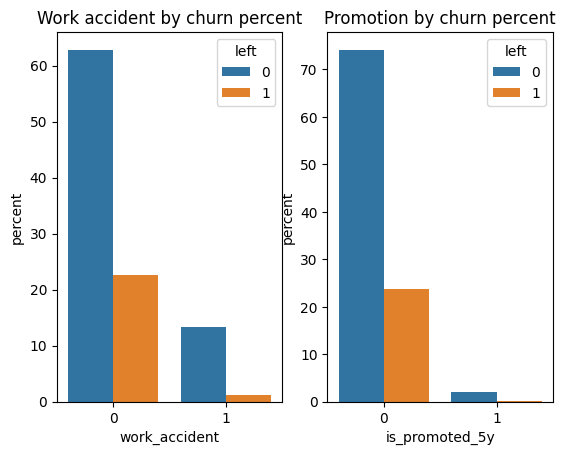

In [20]:
# Explore `work_accident` and `is_promoted_5y` relations with churn
fig, (ax1, ax2) = plt.subplots(1,2)
fig.figsize = (30,10)

sns.countplot(data=df0, x='work_accident', hue='left', ax=ax1, stat='percent')
sns.countplot(data=df0, x='is_promoted_5y', hue='left', ax=ax2, stat='percent')

ax1.set_title("Work accident by churn percent")
ax2.set_title("Promotion by churn percent")

### Key observations:
* No churn for those who worked 7 and more years
* No stayed employees with 7 projects
* Hence, no employees with 7 or more years tenure and 7 projects at once
* Satisfaction level higher among those who left only for tenure years 5 and 6, possibly due to external better offers
* Very low satisfaction level for those who left at 4 years of tenure
* Those who left had more average monthly hours at all `number_project` values except the smallest, 2 projects contribution
* Higher evaluation scores for more often seen among churning employees at above around 220 hours per month, and lower evaluation scores seen more often among churning employees with circa 130-160 average hours per month
* The vast majority of employees work between roughly 135 and 275 hours per month, and many work above 40 hours weekly
* More left than stayed employees at 5 years of tenure, with increasing proportions startin wtih lowest tenure years, 2
* The count of churned is higher at two workload ranges: 130-160 hours per month and 220-310 hours per month
* Churning people exceed those who stayed at 2 projects, probably indicating pre-exit changes, and the proportion then rises from 4 projects and higher, being the lowest at 3 projects
* Only a tiny proportion of all had left the company after a work accident, and this variable might be discounted from the total number of components
* A very small percent of employees have left the company after being promoted in the last 5 years. The overall promotion rates are also very small, below 5%. This also makes discounting this feature from the number of components appropriate.

* Prediction: as the last evaluation score, and likely collinear project numbers and monthly average hours point to 3 distinct groups, and satisfaction level with tenure related to each other in to groups (first lowering satisfaction up to 4 years tenure and then growing), 6 clusters might be likely candidate. 

## Data Modelling

### PCA model build

In [21]:
# As we build the PCA model, only 5 numerical features are preserved to improve analysis.
pca = PCA(n_components=5)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

Let us see explained variance by components.

In [22]:
# Use the attribute of the PCA class
explained_variance = pca.explained_variance_ratio_

print(explained_variance)

[0.28066337 0.16940571 0.14353969 0.13652345 0.10691098]


### KMeans clustering

Let us first create a list with the number of clusters and a function to return inertia values.
Then find the elbow at a certain number of clusters in a visual

In [23]:
# List of possible clusters
num_clust = [i for i in range(2,12)]

# Function to return inertia values
def kmeans_inertia(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints. 
    Returns each k-value's inertia appended to a list.
    """
    
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters = num, random_state=0)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)

    return inertia

Text(0, 0.5, 'Inertia value')

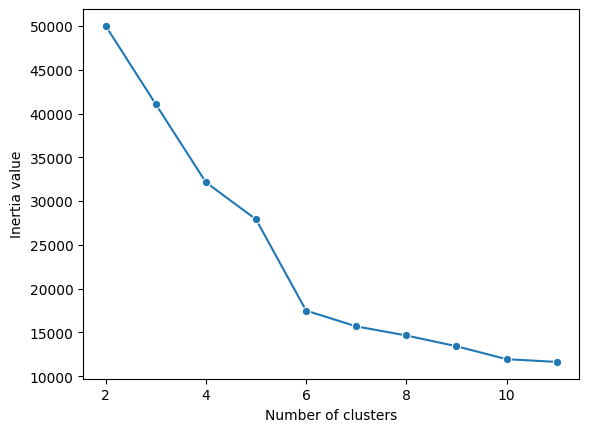

In [24]:
# Use the `kmeans_inertia` function to return the inertia values
inertia_vals = kmeans_inertia(num_clust, X_train)

# Plot inertia values at different `n_clusters` of the Kmeans object

plot = sns.lineplot(x=num_clust, y=inertia_vals, marker = 'o')
plot.set_xlabel("Number of clusters")
plot.set_ylabel("Inertia value")

A clear elbow at 6 clusters is seen.
Let us investigate silhouette values for each cluster number with a defined function and then plot them as well.

In [25]:
# Define the function to get silhouette values

def kmeans_sil(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints.
    Calculates a silhouette score for each k value. 
    Returns each k-value's silhouette score appended to a list.
    """

    sil_scores = []
    for num in num_clusters:
        kms = KMeans(n_clusters = num, random_state=0)
        kms.fit(x_vals)
        sil_scores.append(silhouette_score(x_vals, kms.labels_))
    return sil_scores

Text(0, 0.5, 'Silhouette scores')

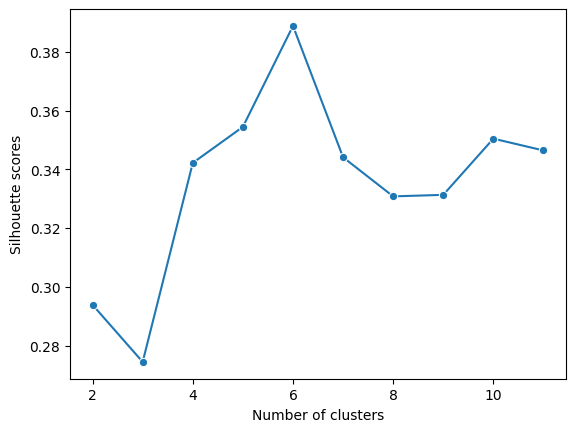

In [26]:
# Use the `kmeans_sil` function and then plot its results
silhouette_scores = kmeans_sil(num_clust, X_train)

# Plot the results

plot = sns.lineplot(x=num_clust, y=silhouette_scores, marker = 'o')
plot.set_xlabel("Number of clusters")
plot.set_ylabel("Silhouette scores")

Use the best number of clusters to fit the data.

In [27]:
# Instantiate the KMeans object and fit the data
kms6 = KMeans(n_clusters = 6, random_state=0)
kms6.fit(df_num)

# Verify if `left` can be differentiated by cluster
df_kms = df_num.copy()
df_kms['cluster']=kms6.labels_

print(df_kms.head())

   satisfaction_level  last_evaluation  number_project  avg_hours_month  \
0                0.38             0.53               2              157   
2                0.11             0.88               7              272   
3                0.72             0.87               5              223   
4                0.37             0.52               2              159   
5                0.41             0.50               2              153   

   tenure_years  work_accident  left  is_promoted_5y  cluster  
0             3              0     1               0        0  
2             4              0     1               0        3  
3             5              0     1               0        1  
4             3              0     1               0        0  
5             3              0     1               0        0  


<Axes: title={'center': 'Clusters by leave status'}, xlabel='(Cluster, left)', ylabel='Size'>

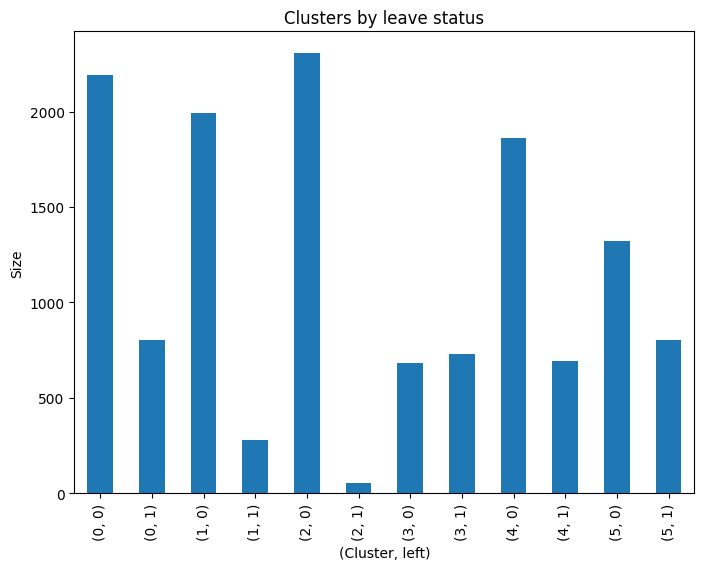

In [28]:
df_kms.groupby(['cluster', 'left']).size().plot.bar(
    title="Clusters by leave status",
    figsize=(8,6),
    ylabel='Size',
    xlabel='(Cluster, left)'
)

Cluster at index 3 is the worst performing, and the best differentiation is at index 2.

## Conclusions

* Despite the clusters were somewhat ill-defined, this might point to the fact that there is generally some dispersion among leaving employees by features, which made 4 out of 6 clusters have significant inaccuracy.
* Although clusterins is good to group data, the stakeholders need to be cautious when interpreting its results and probably search for another marker of churns
* Satisfaction level remains the major component that stands out among others (with high explained variance ratio of over 28%), and proper satisfaction level monitoring can aid stakeholders in actions directed to better identify measures that can help reduce churn and tweak hiring processes to get employee pool that is less prone to leave.